Mapping the Park Fire (2024) via Streaming PlanetScope Mosaics
==================================================

The Park Fire has burned 173,717 hectares beginning on July 24th, 2024 and is still not fully contained at the time this example was created.  In this example, we'll explore using PlanetScope Mosaics data to map the extent of the burned area.  If you haven't already, have a look at the mosaics streaming overview in this repository under `jupyter-notebooks/Basemaps-API/streaming.ipynb` to understand the mechanism we'll be using to access data.

Differences in the Normalized Difference Vegatation Index (NDVI) and the Burned Area Index (BAI) are often useful for mapping burn scar extent.  We'll focus on those two methods in this example, but you could also use other classification techniques rather than simple band-math-focused approaches.

Note that all the methods and code in this example would apply equally to reading in a local geotiff.  We're utilizing full-bit-depth streaming of mosaics data to simulating having a single local file with a global extent, but there is nothing specific to mosaics or Planet data in these examples other than the band order of the data.

NDVI Differences
------------------------
Let's start by investigating the NDVI difference. Fire destroys vegatation, which leads to a reduction in NDVI over vegatated areas. Therefore, an NDVI difference map will often highlight burned areas.

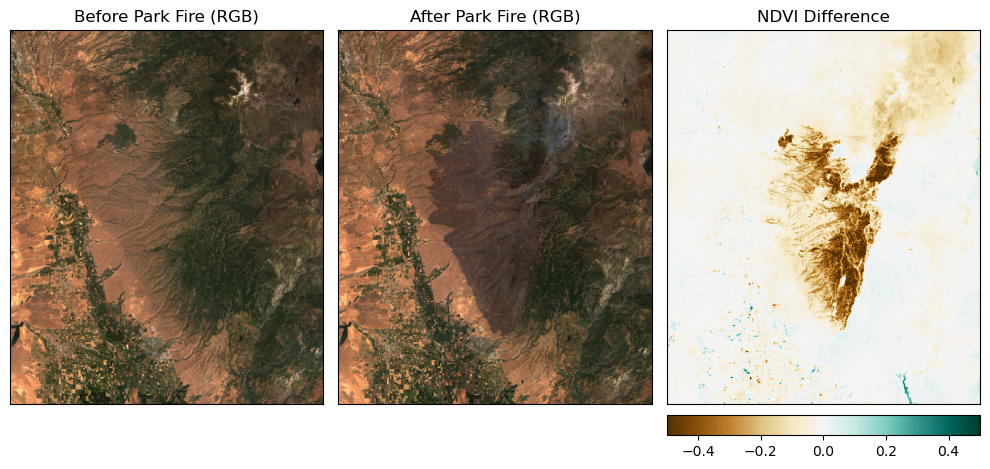

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import rasterio as rio
import rasterio.warp
import rasterio.windows


def wmsxml(mosaic_name, level=15, api_key=None):
    """Create an XML description of Planet's tile services for GDAL. Assumes 8-band"""
    if api_key is None:
        api_key = os.environ.get('PL_API_KEY')
    if api_key is None:
        raise ValueError('If api_key is not specified, you must set PL_API_KEY in the environment')
    
    return f"""<GDAL_WMS>
    <Service name="TMS">
    <ServerUrl>https://tiles.planet.com/basemaps/v1/planet-tiles/{mosaic_name}/gmap/${{z}}/${{x}}/${{y}}.png?api_key={api_key}&amp;format=geotiff&amp;proc=off&amp;empty=404</ServerUrl>
    </Service>
    <DataWindow>
        <UpperLeftX>-20037508.34</UpperLeftX>
        <UpperLeftY>20037508.34</UpperLeftY>
        <LowerRightX>20037508.34</LowerRightX>
        <LowerRightY>-20037508.34</LowerRightY>
        <TileLevel>{level}</TileLevel>
        <TileCountX>1</TileCountX>
        <TileCountY>1</TileCountY>
        <YOrigin>top</YOrigin>
    </DataWindow>
    <Projection>EPSG:3857</Projection>
    <BlockSizeX>256</BlockSizeX>
    <BlockSizeY>256</BlockSizeY>
    <BandsCount>9</BandsCount>
    <DataType>uint16</DataType>
    <ZeroBlockHttpCodes>403,404,503</ZeroBlockHttpCodes>
    <DataValues NoData="0 0 0 0 0 0 0 0 0" min="0 0 0 0 0 0 0 0 0" max="10000 10000 10000 10000 10000 10000 10000 10000 65535" />
    <Cache/>
    </GDAL_WMS>
    """


def read_window(path, bounds):
    """
    Use rasterio to read in a WGS84 bounding box (lon_min, lat_min, 
    lon_max, lat_max) of a raster dataset.
    """
    with rio.open(path) as src:
        bounds = rio.warp.transform_bounds({'init': 'EPSG:4326'}, src.crs, *bounds)
        window = rio.windows.from_bounds(*bounds, src.transform)
        return src.read(window=window)
    
    
def ndvi(data):
    """Normalized Difference Vegatation of 8-band mosaic data"""
    invalid = data[-1] == 0
    red, nir = data[5], data[7]
    val = (nir.astype(np.float32) - red) / (nir + red + 1e-6)
    val[invalid] == np.nan
    return val


def rgb(data, cmax=2500):
    """Visual display of 8-band mosaic data."""
    invalid = data[-1] == 0
    visual = np.clip(data[[5, 3, 1]].astype(np.float32) / cmax, 0, 1)
    for band in visual:
        band[invalid] = np.nan
    return np.moveaxis(visual, 0, -1)
    

# Let's analyze a region around the Park Fire in California, USA
bounds = (-122.3879, 39.5808, -121.2083, 40.6577)
zoom = 10 # At a relatively coarse pixel size for speed...

# We'll use mosaic data from two weeks surrounding the fire
before = "ps_weekly_sen2_normalized_analytic_8b_sr_subscription_2024-07-15_2024-07-22_mosaic"
after = "ps_weekly_sen2_normalized_analytic_8b_sr_subscription_2024-08-05_2024-08-12_mosaic"

# The wmsxml call here returns an XML string, but you could just as easily
# pass in the path to a local geotiff file. We're simply pretending this
# is a single local dataset and letting rasterio do the heavy lifting.
before_data = read_window(wmsxml(before, level=zoom), bounds)
after_data = read_window(wmsxml(after, level=zoom), bounds)

# We'll calculate the difference in NDVI before and after the fire...
ndvi_diff = ndvi(after_data) - ndvi(before_data)

# And make a quick plot of the result...
# To ensure we can make a properly aligned colorbar and still
# have correct interactivity, we'll take a slightly "fancier"
# matplotlib approach than `plt.subplots(ncols=3)`
fig = plt.figure(figsize=(10, 4.7))
gs = gridspec.GridSpec(ncols=3, nrows=21, figure=fig)

ax1 = fig.add_subplot(gs[:-1, 0])
ax1.imshow(rgb(before_data))
ax1.set(title='Before Park Fire (RGB)')

ax2 = fig.add_subplot(gs[:-1, 1], sharex=ax1, sharey=ax1)
ax2.imshow(rgb(after_data))
ax2.set(title='After Park Fire (RGB)')

ax3 = fig.add_subplot(gs[:-1, 2], sharex=ax1, sharey=ax1)
cax = fig.add_subplot(gs[-1, -1])
im = ax3.imshow(ndvi_diff, vmin=-0.5, vmax=0.5, cmap='BrBG')
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
ax3.set(title='NDVI Difference')

for ax in [ax1, ax2, ax3]:
    ax.set(xticks=[], yticks=[])
fig.tight_layout()
fig.subplots_adjust(hspace=0)
plt.show()

An NDVI difference map clearly shows the burn scar, but does not do a good job of highlighting the exact extent of the fire.  That's because the grassy foothills were already quite dry and had a low NDVI before the fire.  Burning did not dramatically change the NDVI values in these areas.  Furthermore, smoke to the northeast of the burned region in the "after" data contributes to a significant region having a lower-than-normal NDVI, which further complicates mapping the extent of the burned area. Also note the spurious high difference values over water (water is quite variable in NDVI) and changes over agricultural fields.

BAI Differences
----------------------

Let's try using a different metric: The Burned Area Index (BAI).  This metric measures how close the spectral response of each pixel is to the NIR and Red values expected from a strongly burned region.  It has an arbitrary scaling (1 / square distance in reflectance) and can produce infinite values, but it does a better job of mapping burned regions than NDVI.  It's most useful when two dates are compared and a difference map is created. Otherwise, non-vegatated areas often have a high BAI value.  Subtracting the BAI values of two different dates avoids false positives that would arise from a thresholding a single image's BAI value and gives a clearer indication of the burned area.

Similar to NDVI differences, BAI differences are often sensitive to water.  To exclude spurious increases over water bodies, we'll exclude all regions where the NIR-based Normalized Difference Water Index (NDWI) is over a threshold. Because it's an NIR-based NDWI and not a SWIR-based NDWI, it will have false positives, and we'll exclude some bare-earth regions and potentially some burned areas if we make the threshold too low. However, excluding bare-earth regions is perfectly acceptable for this analysis, and we only need to make sure we don't exclude any of the burned area via the NDWI threshold.

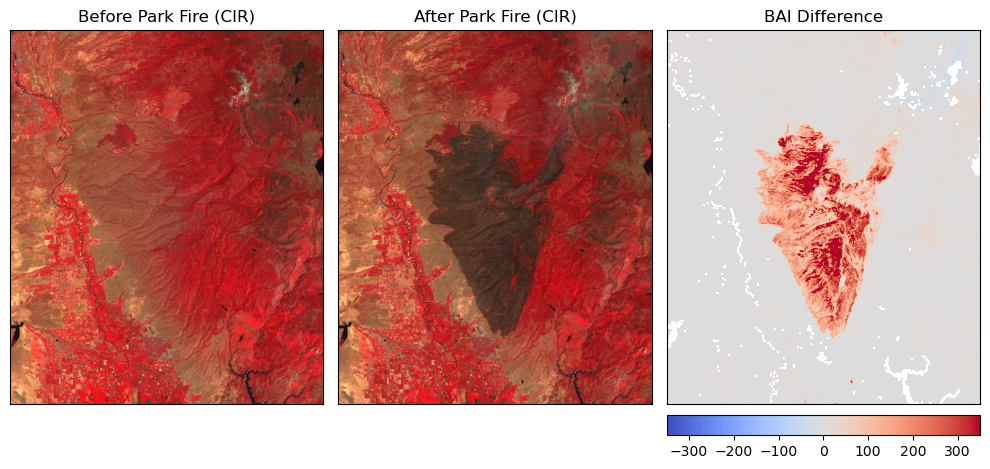

In [2]:
def bai(data):
    """Burned Area Index of 8-band mosaic data."""
    invalid = data[-1] == 0
    red, nir = data[5], data[7]
    red = red.astype(np.float32) / 10000
    nir = nir.astype(np.float32) / 10000
    val = 1 / ((0.1 - red)**2 + (0.06 - nir)**2)
    val[invalid] = np.nan
    return val


def ndwi(data):
    """Normalized Difference Water Index of 8-band mosaic data"""
    invalid = data[-1] == 0
    green, nir = data[3], data[7]
    val = (green.astype(np.float32) - nir) / (green + nir)
    val[invalid] == np.nan
    return val


def cir(data, cmax=4000):
    """False color infrared display of 8-band mosaic data."""
    invalid = data[-1] == 0
    visual = np.clip(data[[7, 5, 3]].astype(np.float32) / cmax, 0, 1)
    for band in visual:
        band[invalid] = np.nan
    return np.moveaxis(visual, 0, -1)


# We'll work with the difference in BAI between the two timeframes
bai_diff = bai(after_data) - bai(before_data)

# Let's exclude pixels over water...
# This is an arbitrary threshold that you'll want to tune for your specific case
water_thresh = -0.15
water = (ndwi(after_data) > water_thresh) | (ndwi(before_data) > water_thresh)
bai_diff[water] = np.nan

# Now let's visualize the results (again, with a "fancy" approach for the cbar)
fig = plt.figure(figsize=(10, 4.7))
gs = gridspec.GridSpec(ncols=3, nrows=21, figure=fig)

ax1 = fig.add_subplot(gs[:-1, 0])
ax1.imshow(cir(before_data))
ax1.set(title='Before Park Fire (CIR)')

ax2 = fig.add_subplot(gs[:-1, 1], sharex=ax1, sharey=ax1)
ax2.imshow(cir(after_data))
ax2.set(title='After Park Fire (CIR)')

ax3 = fig.add_subplot(gs[:-1, 2], sharex=ax1, sharey=ax1)
cax = fig.add_subplot(gs[-1, -1])
im = ax3.imshow(bai_diff, vmin=-350, vmax=350, cmap='coolwarm')
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
ax3.set(title='BAI Difference')

for ax in [ax1, ax2, ax3]:
    ax.set(xticks=[], yticks=[])
fig.tight_layout()
fig.subplots_adjust(hspace=0)
plt.show()

Segmentation and Cleanup
---------------------------------------

Now let's threshold the region with a high BAI difference and vectorize it to GeoJSON.  As is commonly the case with threshold-based segmentations, we'll need to do a bit of post-processing to clean up the classified region and produce a robust result.

If we wanted to avoid a hand-tuned global threshold, Otsu Thresholding would work well for this case. However, for simplicity of implementation, we'll stick to a simple, hand-chosen global threshold here.

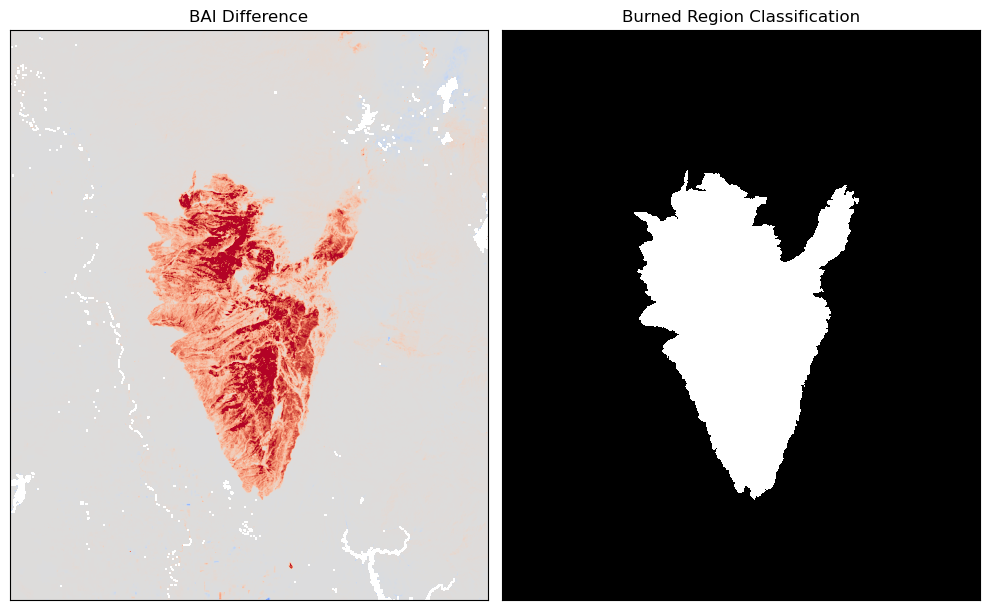

In [3]:
import scipy.ndimage


# We'll start by considering all areas where the BAI increased by at least this much..
# This is an arbitrary threshold that you'll want to tune for your specific case
burned_region = bai_diff > 25

# Clean up small features in the classification...
burned_region = scipy.ndimage.median_filter(burned_region, 3)

# We'll fill in all the holes, as well. You may not always want
# to do this. E.g. you may want to map the unburned regions inside
# the burn scar. Remove this line to try leaving holes...
burned_region = scipy.ndimage.binary_fill_holes(burned_region)

# Now let's extract only the largest contiguous area
label, num_features = scipy.ndimage.label(burned_region)
counts = np.bincount(label.ravel())
burned_region[label != np.argmax(counts[1:]) + 1] = 0

fig, axes = plt.subplots(ncols=2, figsize=(10, 8))
axes[0].imshow(bai_diff, vmin=-350, vmax=350, cmap='coolwarm')
axes[0].set(title='BAI Difference')
axes[1].imshow(burned_region, interpolation='nearest', cmap='gray')
axes[1].set(title='Burned Region Classification')
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
fig.tight_layout()
plt.show()

And now let's convert that to GeoJSON. Note that the approach we're using here would apply equally to any type of data, not only a mosaic.

In [4]:
import json

import rasterio.features

# Remember we're working with a smaller window and not the full (global) raster...

def vectorize(mask, path, bounds=None):
    """
    Create a FeatureCollection of areas where ``mask`` is True. This 
    assumes ``mask`` represents a sub-region of the overall dataset.
    
    :param ndarray mask: A boolean 2D raster classification
    :param str path: A gdal dataset description (e.g. file path/etc)
    :param tuple bounds: The WGS84 lonmin,latmin,lonmax,latmax of mask
    """
    with rio.open(path) as src:
        if bounds is None:
            bounds = src.bounds
        else:
            bounds = rio.warp.transform_bounds({'init': 'EPSG:4326'}, src.crs, *bounds)
            
        # First let's redo the key parts of the "read bounding box"
        # from the read_window method so that we know where the array
        # we're going to vectorize "lives" in the larger raster.
        window = rio.windows.from_bounds(*bounds, src.transform)
        new_trans = rio.windows.transform(window, src.transform)
    
    # Now let's vectorize it.
    shapes = rio.features.shapes(mask.view(np.uint8), mask, transform=new_trans)
    # We don't care about the value, only the polygon...
    shapes = [x[0] for x in shapes]
    
    # And transform those back to WGS84.
    shapes = rasterio.warp.transform_geom(src.crs, {'init': 'EPSG:4326'}, shapes) 
    
    # Now we'll make a FeatureCollection
    output = {'type': 'FeatureCollection', 'features': []}
    for geom in shapes:
        feat = {'type': 'Feature', 'properties': {}, 'geometry': geom}
        output['features'].append(feat)
    return output


result = vectorize(burned_region, wmsxml(before, level=zoom), bounds)

with open('park_fire.geojson', 'w') as outfile:
    json.dump(result, outfile)

And let's make a quick display of that in geographic coordinates (we'll also approximately correct for shape distortion in geographic projections):

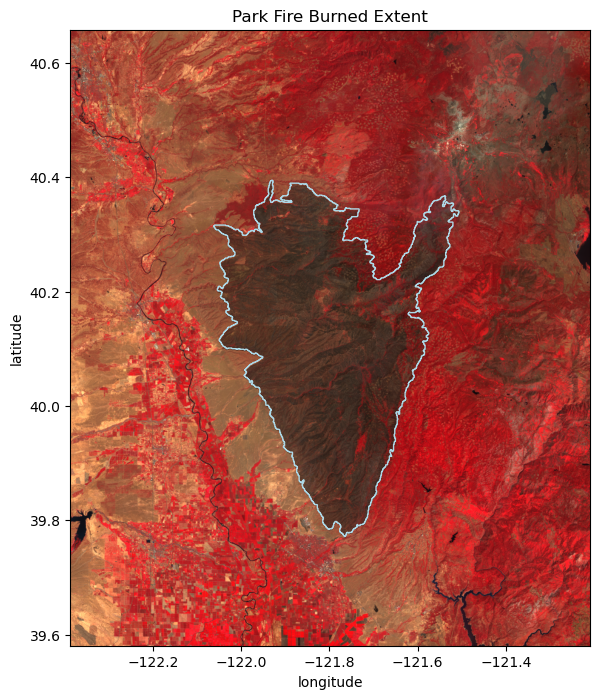

In [5]:
from descartes import PolygonPatch


fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cir(after_data), extent=(bounds[0], bounds[2], bounds[1], bounds[3]), origin='upper')

for feature in result['features']:
    ax.add_patch(PolygonPatch(feature['geometry'], fc='none', ec='lightblue'))

# We're displaying in geographic WGS84 instead of Mercator. Geographic projections
# have a systematic shape, direction, and area distortion. Let's coarsely correct 
# for the direction/shape distortion of the geographic display to keep things 
# consistent with the earlier Mercator displays (which accurately show shape)
longitude_distortion = np.cos(np.radians(bounds[1]))
ax.set(
    xlabel='longitude', 
    ylabel='latitude', 
    title='Park Fire Burned Extent', 
    aspect=1/longitude_distortion,
)

plt.show()
                       

In this case, the BAI difference did a very good job of mapping the extent of the burned area! (With hand-tuned thresholds, however.)